# Evaluation of Mobilenet V2 using CIFAR-100
In this notebook we will go through key evaluation metrics for CNN in order to analyse how efficiently and accurately Mobilenet V2 model predicts on data CIFAR-100.

## Setup

In [224]:
import os, time, torch
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

from model import TransferModel
from data_preparation.CIFAR_100.data_cifar_100 import test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


Define specific variables for this evaluation script.

In [225]:
model_name = 'MobileNet V2'
dataset_name = 'CIFAR-100'
class_labels = test_loader.dataset.classes
class_labels[:8]

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle']

Import data for evaluation taken from training step.

In [226]:
full_history = pd.read_csv('data_evaluation_mobilenet_v2/CIFAR_100/mobilenet_v2_cifar100_full_best_training_history.csv')
full_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [227]:
head_history = pd.read_csv('data_evaluation_mobilenet_v2/CIFAR_100/mobilenet_v2_cifar100_head_best_training_history.csv')
head_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [228]:
lastblock_history = pd.read_csv('data_evaluation_mobilenet_v2/CIFAR_100/mobilenet_v2_cifar100_lastblock_best_training_history.csv')
lastblock_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [229]:
test_loss = pd.read_csv('data_evaluation_mobilenet_v2/CIFAR_100/mobilenet_v2_test_loss_list.csv')
test_loss.columns

Index(['batch_loss'], dtype='object')

In [230]:
test_pred = pd.read_csv('data_evaluation_mobilenet_v2/CIFAR_100/mobilenet_v2_test_predictions.csv')
y_true = test_pred.True_Label
y_pred = test_pred.Predicted_Label
test_pred.columns

Index(['True_Label', 'Predicted_Label'], dtype='object')

In [231]:
model_path = 'data_evaluation_mobilenet_v2/CIFAR_100/mobilenet_v2_cifar100_full_best.pth'

## Visualisate Model Predictions

Create instance of our model.

In [232]:
model = TransferModel(num_classes=100, backbone='mobilenet_v2', pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Function to visualisate model predictions (with True and Predicted labels).

In [233]:
def visualize_model_predictions(model, loader, class_labels, target_class=None, num_images=5, device="cpu"):
    samples = [] 
    
    if target_class is not None: 
        target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    plt.figure(figsize=(15, 4))
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    for i in range(len(samples)):
        ax = plt.subplot(1, num_images, i + 1)
        
        img_tensor, true_id, pred_id = samples[i]
        img = img_tensor.permute((1, 2, 0)).numpy() 
        
        # Denormalization step
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean # (img - mean) / std
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        
        true_label = class_labels[true_id]
        pred_label = class_labels[pred_id]
        
        # Green for correct, Red for wrong
        color = 'green' if true_id == pred_id else 'red'
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis("off")
    plt.show()

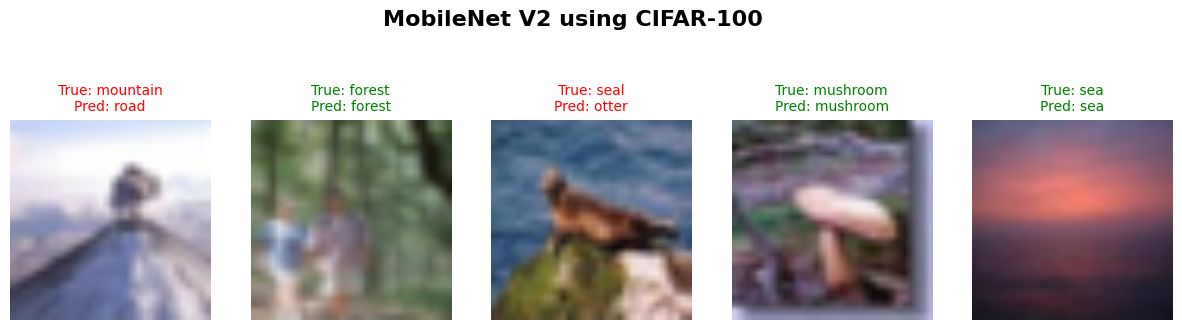

In [234]:
visualize_model_predictions(model, test_loader, class_labels, num_images=5, device=device)

## Training Dynamics
### Stability & Overfitting Check
In this section we will compare how well model was trained during 3 different transfer learning strategies:
* **Full fine-tuning (full)** -> Training all layers of the network.
* **Linear probing (head)** -> Training only the final classification head while keeping the backbone frozen.
* **Partial fine-tuning (last)** -> Unfreezing the final blocks of the MobileNet architecture to allow for feature adaptation.

In [235]:
# define dictionary to store for each strategy -> name(key), df, color
strategies = {
    "Head Only": {"df": head_history, "color": "#e57373"},
    "Last Block": {"df": lastblock_history, "color": "#ffb74d"},
    "Full Tuning": {"df": full_history, "color": "#81c784"}
}

### Max Accuracy (Top-1 Accuracy)

This metric shows what percentage of the time model's highest-probability prediction matches with actual label.
$$\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(\hat{y}_i = y_i)$$

Max accuracy

Head Only: 55.14%
Last Block: 67.44%
Full Tuning: 75.58%


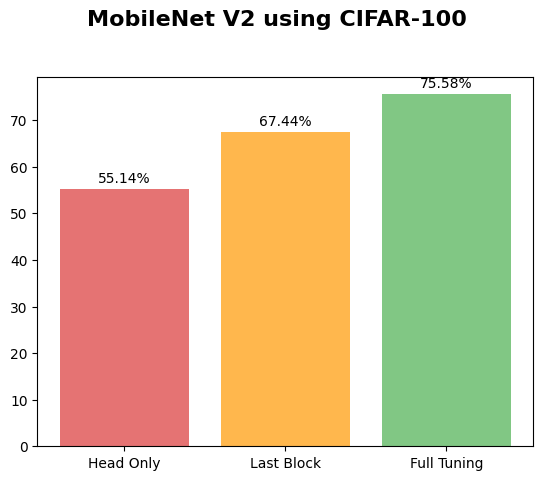

In [236]:
print("Max accuracy\n")

for key, item in strategies.items():
    item['maxAcc'] = item['df']['val_acc'].max() * 100
    print(f"{key}: {item['maxAcc']:.2f}%")

bars = plt.bar(strategies.keys(), [strategies[i]['maxAcc'] for i in strategies], color=[strategies[i]['color'] for i in strategies])
plt.bar_label(bars, padding=3, fmt='%.2f%%')
plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
pass

**Head Only results:** This strategy assumes to freeze entire feature extractor and train only last classifier. The score is the lowest which confirms that generic pre-trained features are not enough for CIFAR-100.

<br>**Last Block results:** By unfreezing just the final layers of MobileNetV2, we can see the improvements of the max accuracy score. This is due to that model takes into account some generic features, but still fails to extract "high-level" features (for complicated classes).

<br>**Full Tuning results:** Unfreezing the entire network, results in the highest accuracy.

### Combined Validation Accuracy
With this metric we can compare learning capabilities of three strategies of training model.

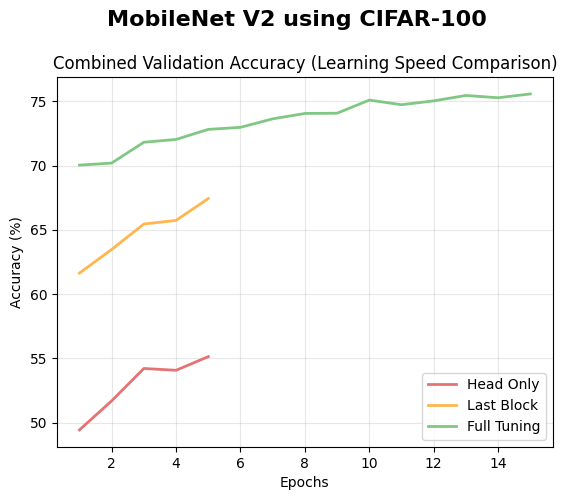

In [237]:
for key, item in strategies.items():
    df = item['df']
    epochs = range(1, len(df) + 1)
    plt.plot(epochs, df['val_acc'] * 100, label=key, color=item['color'], linewidth=2)

plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
plt.title('Combined Validation Accuracy (Learning Speed Comparison)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Full Model Strategy**
Shows the best results, since its accuracy starts at ~70%, which is much higher then last block and head only strategy. This shows that Deep Fine-Tuning is essential for CIFAR-100.

<br>**Head Only Strategy**
We can see that accuracy curve starts below 50% and barely reaches 55% -> underfitting. It confirms that the pre-trained features alone were too generic for this specific task.

<br>**Last Block Strategy**
This strategy shows intermediate result, showing that unfreezing the last convolutional block helps model to learn some of high-level features specific to CIFAR-100, but nonetheless nuances would not be taken into account.

### Training Loss vs Validation Loss

These graphs will show us how well model generalizes to unseen data depending on which training strategy was used.

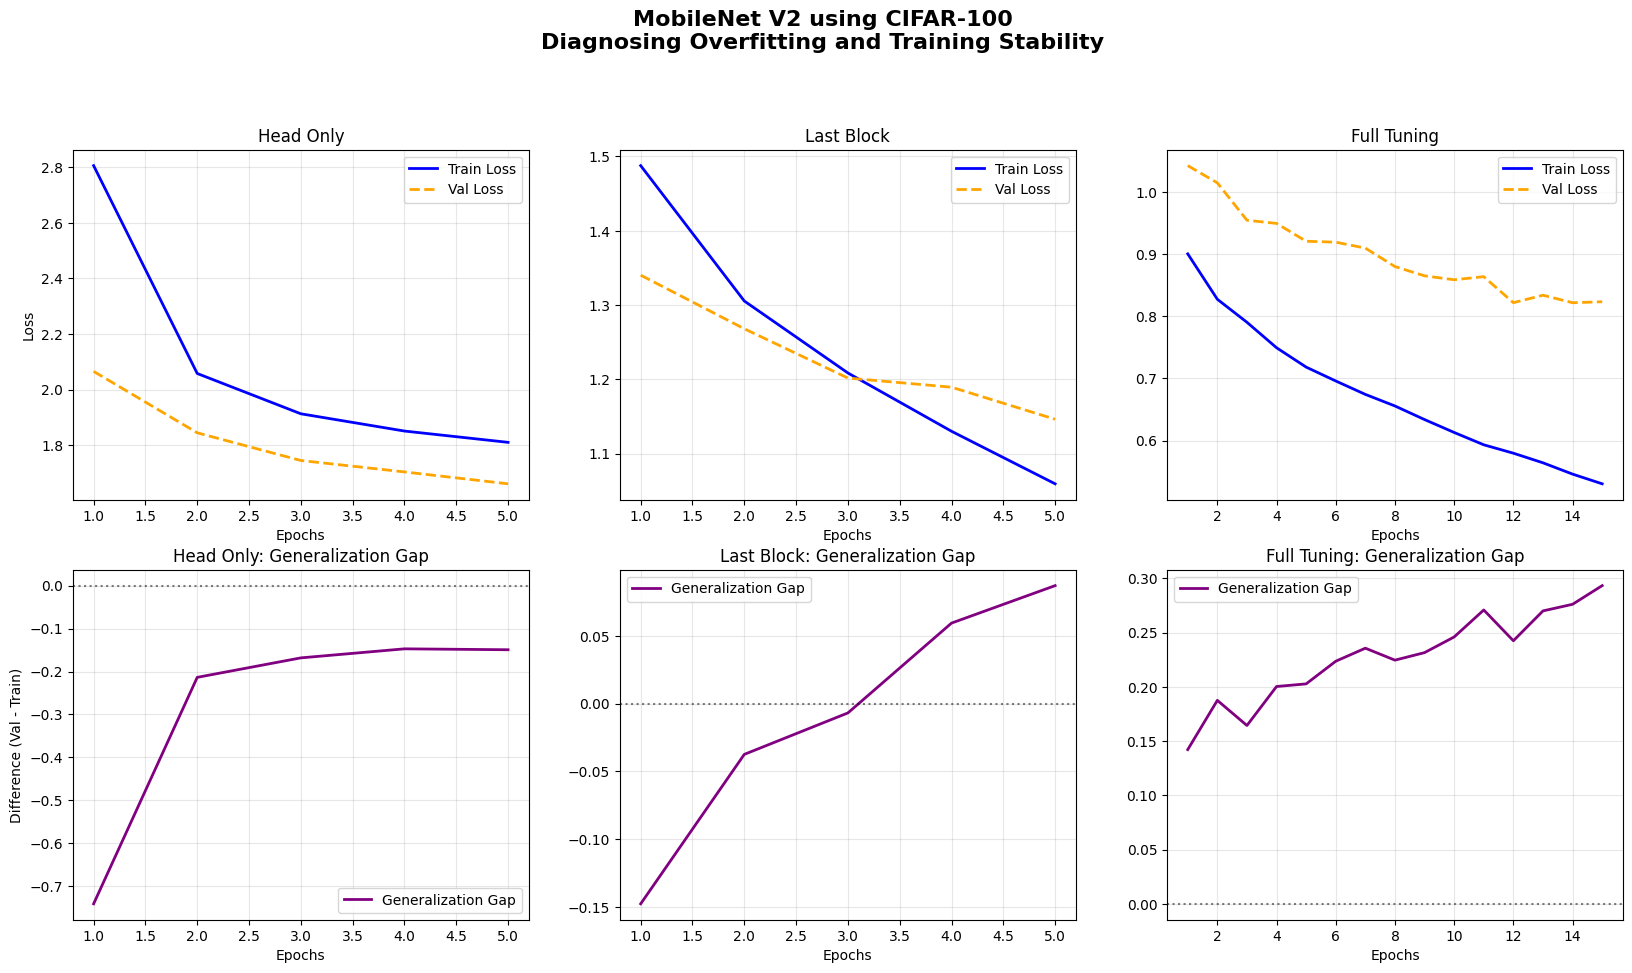

In [238]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, (key, item) in zip(axes[0], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)
    
    #Training Loss
    ax.plot(epochs, df['train_loss'], label='Train Loss', color='blue', linewidth=2)
    
    #Validation Loss
    ax.plot(epochs, df['val_loss'], label='Val Loss', color='orange', linestyle='--', linewidth=2)
    
    ax.set_title(f'{key}', )
    ax.set_xlabel('Epochs')

    if key == "Head Only":  ax.set_ylabel('Loss')

    ax.legend()
    ax.grid(True, alpha=0.3)

#plotting Generalisation Gap Metric
for ax, (key, item) in zip(axes[1], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)

    # Calculate gap
    df['gap'] = df['val_loss'] - df['train_loss']
    
    ax.plot(epochs, df['gap'], label='Generalization Gap', color='purple', linewidth=2)
    ax.axhline(y=0, color='black', linestyle=':', alpha=0.5)
    
    ax.set_title(f'{key}: Generalization Gap')
    ax.set_xlabel('Epochs')

    if key == "Head Only": ax.set_ylabel('Difference (Val - Train)')
    
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{model_name} using {dataset_name}\nDiagnosing Overfitting and Training Stability', fontsize=16, weight='bold', y=1.02)
plt.show()

**Head Only:**
* loss curve -> validation loss curve is lower than training one. This shows that training images is harder to learn, while validation images are clean
* generalisation gap -> negative
> **Underfitting** -> high bias -> model fails to learn the "hard" training examples effectively.

<br>**Last Block:**
* loss curve -> crosses at ~epoch 3. So training loss becomes below validation loss
* generalisation gap -> rises from negative (crosses zero at ~3 epoch)
> **Balanced** -> from generalisation gap we can see theoretical point where model's capacity matches the data complexity (in our case ~3 epoch). So in general model learn well, but final accuracy is still low (67%).

<br>**Full Model:**
* loss curve -> validation loss curve is significantly higher than training loss one
* generalisation gap -> rises and completely positive 
> **Small overfitting** -> high varience -> by generalisation gap (purple curve) we can notice that in this case model starts to memorize the training data. But the high accuracy score shows that we can accept some overfitting to achive highest precision.

## High-Level Performance 
### Global Metrics Comparison
Aim is to analyse the model accuracy, precision and f1-score from the best training strategy (by generating theirs distributions).

Function to plot distribution of metrics.

In [239]:
def print_distribution(df_report, metric:str):
    scores = (df_report[metric] * 100).copy()

    #we drop the global metrics so we only analyze the specific classes (apple, bear, etc.)
    summary_rows = ['accuracy', 'macro avg', 'weighted avg']
    class_scores = scores.drop(summary_rows, errors='ignore')

    # Kernel Density Estimate (KDE) line
    sns.histplot(class_scores, kde=True, bins=15, edgecolor='white', color='#4c72b0')

    # mean performance
    mean_val = class_scores.mean()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean {metric}: {mean_val:.1f}%')

    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.title(f'Distribution of {metric} Per Class', fontsize=14, weight='bold')
    plt.xlabel(f'{metric} (%)', fontsize=12)
    plt.ylabel('Number of Classes', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

Global characteristics

In [240]:
# generate report for all 100 classes
report_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=class_labels, 
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()
df_report.head(5)

,precision,recall,f1-score,support
apple,0.948454,0.92,0.934010,100.0
aquarium_fish,0.864078,0.89,0.876847,100.0
baby,0.706522,0.65,0.677083,100.0
bear,0.715909,0.63,0.670213,100.0
beaver,0.535714,0.60,0.566038,100.0


To get main performance metrics 'classification_report' was used.

In [241]:
report = classification_report(y_true, y_pred, output_dict=True)

print(f"Global Accuracy:    {report['accuracy'] * 100:.2f}%")
print(f"Macro Precision:    {report['macro avg']['precision'] * 100:.2f}%")
print(f"Weighted Precision: {report['weighted avg']['precision'] * 100:.2f}%")
print(f"Macro F1-Score:     {report['macro avg']['f1-score'] * 100:.2f}%")

Global Accuracy:    75.89%
Macro Precision:    76.07%
Weighted Precision: 76.07%
Macro F1-Score:     75.87%


### Precision
This metrics shows us quality or purity of models predictions. High precision means that we can be confident that model identifies images correctly, for low - model labels many things even when they are incorrect, leading to many false alarms.

$$Precision = \frac{TP}{TP + FP}$$
> Out of all the items the model **claimed** to catch, how many were **actually** positive?

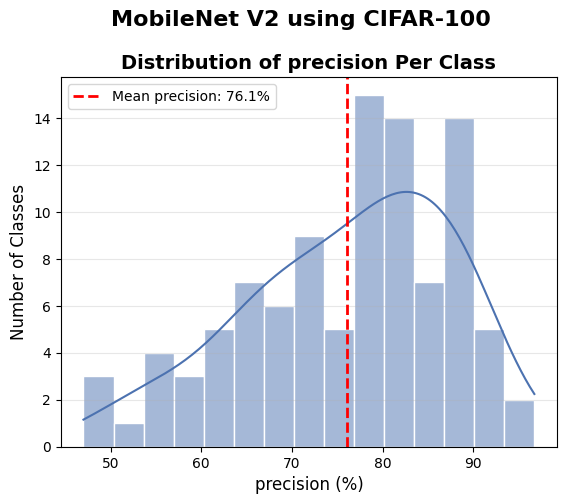

In [242]:
print_distribution(df_report,'precision')

From graph we can clearly see that we have high varience. Best percision nearly 95%+ while the worst below 50%. Distribution is not symmetric.

<br>From problematic side, model is pretty reliable (mean 76.1%), but if user queries one of the classes in the "left tail", the results will be wrong half the time.

### Recall
This metric measures the "completeness" of your model's predictions. We can find it by the formula:

$$Recall = \frac{TP}{TP + FN}$$

> Out of all the items that are **actually** positive, how many did the model **manage** to catch?

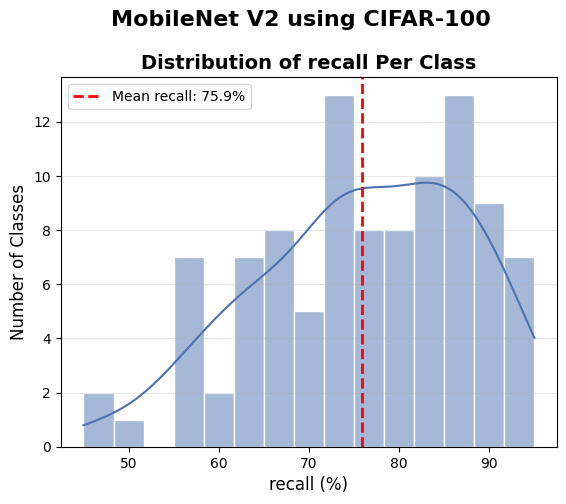

In [243]:
print_distribution(df_report,'recall')

In general from histogram we can see that recall scores concentrated significant between 70% and 90% with mean recall of 75.9%. Also we have negatively skewed distribution -> this means model performs well on the majority of classes.

### F1-Score
$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
> How well does the model **balance** catching all the **right items** (Recall) while **avoiding wrong** ones (Precision)?

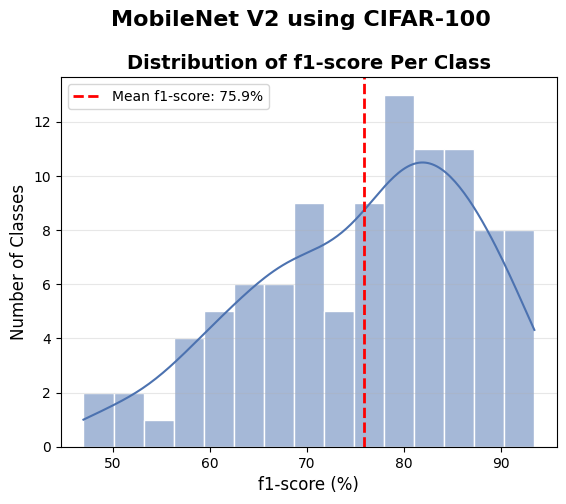

In [244]:
print_distribution(df_report,'f1-score')

From graph we can see that distribution of f1-scores across multiple classes shows a mean of 75.9% with a clear concentration of higher-performing classes in the 75% to 90% range.

<br>So model has strongly good overall performance, but for potential issues there is roughly 2–5 classes with f1-score below 55%.

## Class Level Analytics
### Confusion Matrix
Using confusion matrix we can see not only one single score like for accuracy for example, but also we can easily track where and how those mistakes occurred.

<br>In our case for CIFAR-100 we will firstly generate 100 matrices with 2x2 grid. It will show binary implementation of confusion matrices for each class separately. Then we will see confusion matrix in heatmap implementation which will help us to extract top 10 wrongly classified classes.

Binary confusion matrix:
$$\begin{bmatrix}
\text{True Negatives (TN)} & \text{False Positives (FP)} \\
\text{False Negatives (FN)} & \text{True Positives (TP)}
\end{bmatrix}$$

In [245]:
#make y_true and y_pred to have str classes names not numbers
y_true_classes = [class_labels[i] for i in y_true]
y_pred_classes = [class_labels[i] for i in y_pred]

# calculates confusion matrix for each class
overall_confusion_matrix = confusion_matrix(y_true, y_pred)
per_class_confusion_matrices = multilabel_confusion_matrix(y_true_classes, y_pred_classes, labels=class_labels)

n = 3
print(f'Confusion matrices for {n} classes\n')
for i in range(n):
    print(f'{class_labels[i]}')
    print(per_class_confusion_matrices[i],'\n')

Confusion matrices for 3 classes

apple
[[9895    5]
 [   8   92]] 

aquarium_fish
[[9886   14]
 [  11   89]] 

baby
[[9873   27]
 [  35   65]] 



To understand more easily what confusion matrices mean let's analyse one case from above

In [246]:
def print_analytics_of_conf_matrix(cm, target_class):
    target_class_id = class_labels.index(target_class) if type(target_class)==str else target_class
    target_class_name = target_class if type(target_class)==str else target_class

    target_cm = cm[target_class_id]

    print(f'Confusion matrix for {target_class_name}')
    print(target_cm)
    
    indices = [i for i, x in enumerate(y_true) if x == target_class_id] # actual label
    predictions_for_target = [y_pred[i] for i in indices] # predicts

    counts = Counter(predictions_for_target) # count

    print(f"\nWhen image was actually '{target_class_name}', but the model predicted:")
    for pred_id, count in counts.most_common(5):
        print(f" - {class_labels[pred_id]}: {count} times")

In [247]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'apple')

Confusion matrix for apple
[[9895    5]
 [   8   92]]

When image was actually 'apple', but the model predicted:
 - apple: 92 times
 - pear: 2 times
 - bowl: 2 times
 - sweet_pepper: 1 times
 - orange: 1 times


Plot of confusion matrix where rows represents true class label, columns - predicted class and diagonal represents correct predictions. All not diagonal cells represents mistakes.

In [248]:
def conf_matrix_heatmap(cm, model_name, data_name, dots_to_plot:list[list[int]]=None, class_labels=None):
    sns.heatmap(cm, 
                annot=False, # if true numbers will appear
                cmap='Blues', # color 'Blues' or 'viridis' 
                vmax=20,
                cbar_kws={'label': 'Number of Images'}
                )           
    if dots_to_plot:
        x_coords = []
        y_coords = []

        for true_id, pred_id in dots_to_plot:
            x_coords.append(pred_id + 0.5)  # -> to be in middle of square
            y_coords.append(true_id + 0.5)
            
            print(f"Marking: {class_labels[true_id]} (ID {true_id}) -> {class_labels[pred_id]} (ID {pred_id})")
    
        plt.scatter(x_coords, y_coords, color='red', marker='o', linewidth=2)
        
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.xlabel('Predicted Class ID')
    plt.ylabel('True Class ID')
    plt.show()

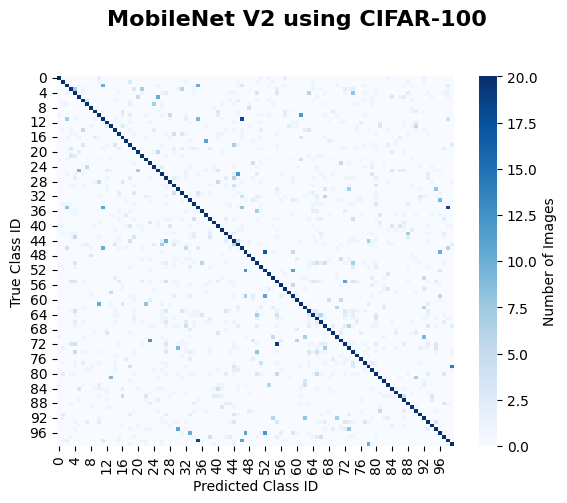

In [249]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name)

How we can use confusion matrix?

In [250]:
def get_top_confusions(y_true, y_pred, class_names, top_n=10):
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0) # Zero out correct predictions (diagonal) to find errors
    
    pairs = []
    for i in range(100):
        for j in range(100):
            if cm[i, j] > 0:
                pairs.append((i, j, cm[i, j]))
    
    # Sort in descending order
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f">>> Top {top_n} Confusions <<<")
    for i in range(min(top_n, len(pairs))):
        true_idx, pred_idx, count = pairs[i]
        
        t_name = class_names[true_idx] if class_names else str(true_idx)
        p_name = class_names[pred_idx] if class_names else str(pred_idx)
        
        print(f"True: {class_labels.index(t_name)} - {t_name:<15} Predicted: {class_labels.index(p_name)} - {p_name:<15} Count: {count}")
        
get_top_confusions(y_true,y_pred,class_labels)

>>> Top 10 Confusions <<<
True: 72 - seal            Predicted: 55 - otter           Count: 19
True: 11 - boy             Predicted: 46 - man             Count: 18
True: 35 - girl            Predicted: 98 - woman           Count: 18
True: 98 - woman           Predicted: 35 - girl            Count: 18
True: 47 - maple_tree      Predicted: 52 - oak_tree        Count: 17
True: 78 - snake           Predicted: 99 - worm            Count: 14
True: 10 - bowl            Predicted: 61 - plate           Count: 12
True: 26 - crab            Predicted: 45 - lobster         Count: 12
True: 52 - oak_tree        Predicted: 47 - maple_tree      Count: 12
True: 71 - sea             Predicted: 23 - cloud           Count: 12


From top 10 confusions we can spot that model has troubles to classify boy <-> man, girl <-> woman. Below let's inspect why model classifies wrongly pair girl <-> woman.

Marking: girl (ID 35) -> woman (ID 98)
Marking: woman (ID 98) -> girl (ID 35)


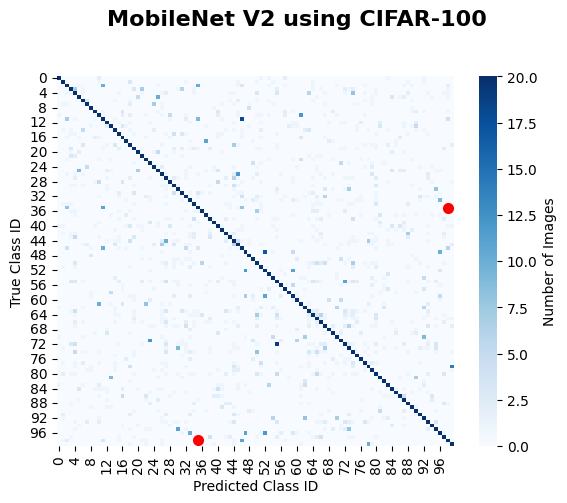

In [257]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name, dots_to_plot=[[35,98], [98,35]], class_labels=class_labels)

In [258]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'girl')

Confusion matrix for girl
[[9849   51]
 [  49   51]]

When image was actually 'girl', but the model predicted:
 - girl: 51 times
 - woman: 18 times
 - boy: 11 times
 - man: 8 times
 - baby: 8 times


We can also see these cases on actual data.

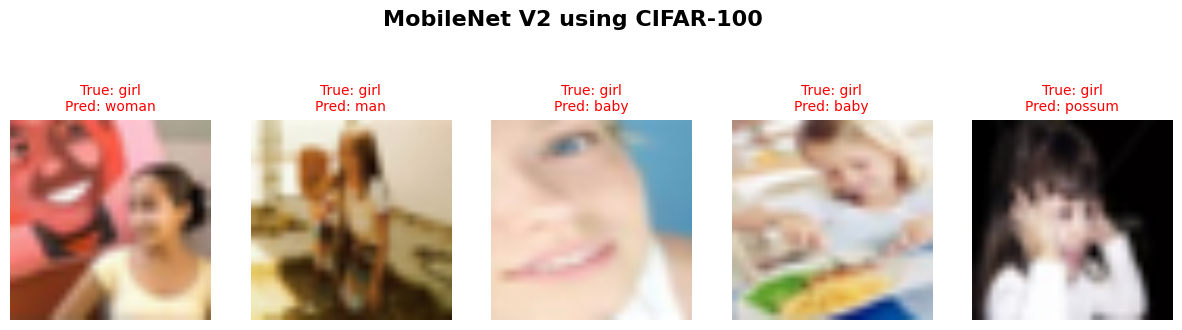

In [ ]:
visualize_model_predictions(model,test_loader,class_labels,'girl')

## Efficiency Analytics
Main idea of this section is to analyse disk space required to store model, how much parameters model has, time of forward pass duration (how much time it takes from the moment an input tensor enters the first layer until the probability vector exits the final layer).

In [253]:
def get_efficiency_metrics(model, loader, device, model_path):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total numb of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples

    print(f">>> Global Efficiency & Confidence Metrics")
    print(f"Model Size:       {size_mb:.2f} MB")
    print(f"Total Params:     {params:,}")
    print(f"Inference Time:   {avg_inference_time*1000:.2f} ms per image")
  
    return size_mb, params, avg_inference_time

get_efficiency_metrics(model, test_loader, device, model_path)

>>> Global Efficiency & Confidence Metrics
Model Size:       9.22 MB
Total Params:     2,351,972
Inference Time:   2.15 ms per image


(9.21540641784668, 2351972, 0.002154156227003444)

## Conclusions

### Training Strategy
The analysis confirms **Full Fine-Tuning** as the necessary approach for this dataset.
* **Head Only (~55% range)**: Resulted in significant underfitting. The generic features from ImageNet were too distinct from the specific fine-grained classes of CIFAR-100 to work without adaptation.
* **Full Tuning (~76%)**: Achieved the best performance. Unfreezing the entire network allowed the lightweight MobileNet architecture to adapt its filters to the complex nuances of 100 different classes, although it does not reach the same highs as ResNet-18 (which reached ~80%).

### Model Reliability & Balance
The model shows a very consistent but "middle-of-the-road" performance profile, with **Precision, Recall, and F1-Score all hovering around 76%**.
* **Uniformity**: The model treats False Positives and False Negatives symmetrically, meaning it doesn't have a strong bias toward one type of error.
* **Variance**: While generally reliable, there is a "long tail" of about 2–5 difficult classes where performance dips significantly (metrics <55%), indicating specific blind spots in the model's understanding.

### Error Analysis
The errors are heavily **semantic** rather than random, driven by the difficulty of distinguishing sub-classes within super-categories.
* **Seal ↔ Otter**: High confusion due to similar aquatic backgrounds and body shapes.
* **Boy ↔ Man / Girl ↔ Woman**: The model correctly identifies "Humans" but struggles to distinguish age/gender sub-groups.
This suggests the model has learned the *concepts* well but lacks the capacity or resolution to separate highly similar variations of those concepts.

### Efficiency
MobileNet V2 shines in efficiency. Despite the lower accuracy compared to ResNet, it offers a highly compact footprint and rapid inference speeds. It represents a classic trade-off: it is the ideal choice for **edge deployment** where resources are constrained, provided that a ~4% drop in accuracy (compared to ResNet-18) is acceptable for the application.